In [1]:
#pip install https://github.com/stefanloock/pyshearlab/archive/master.zip

# Tutorial for Plug-and-Play

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import scipy.io
import pywt    # PyWavelets - Wavelet Transforms in Python
import bm3d
from skimage.metrics import structural_similarity as ssim

import torch

from numba import jit
import pylops
from Tools.wavelet_utils import *
from Tools.tv_utils import *
from Tools.measurement_tools import *
from Tools.FB import *
from Tools.tools import *
from Tools.denoiser import *

## 1- Test some denoisers

Display original image size:
(321, 481)


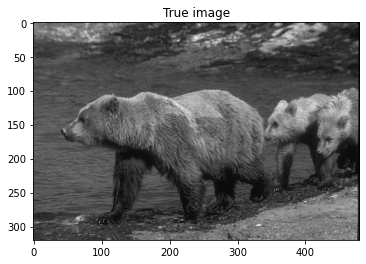

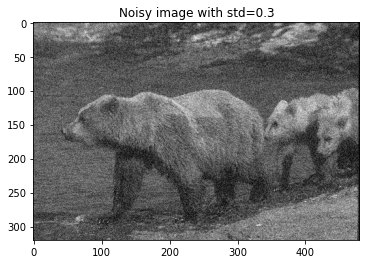

In [3]:
# load image (RGB and convert to grayscale)
im = Image.open('images/bears.jpg').convert('L')
#im = Image.open('images/shepp_logan_phantom.png').convert('L')
#im = Image.open('images/cameraman.png').convert('L')
xtrue = np.array(im) 
xtrue = xtrue / xtrue.max()

print("Display original image size:")
print(xtrue.shape)
# convert to even size
if xtrue.shape[0]%2 == 1:
    xtrue = xtrue[:-1,...]
if xtrue.shape[1]%2 == 1:
    xtrue = xtrue[...,:-1]
nx, ny = xtrue.shape

# Create noisy measurement
std_noise = 0.3
xnoisy = xtrue+std_noise*np.random.rand(nx,ny) 
imshowgray(xtrue, 'True image')
imshowgray(xnoisy, 'Noisy image with std='+str(std_noise))

### 1.1- BM3D
https://pypi.org/project/bm3d/

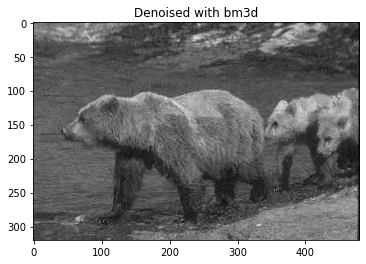

In [4]:
reg_par = 0.2*std_noise
xbm3d=bm3d.bm3d(xnoisy, reg_par)
imshowgray(xbm3d, 'Denoised with bm3d')

### 1.3- DRUNet

https://github.com/cszn/DPIR/tree/master/model_zoo

In [5]:
import torch.nn as nn

from external.network_unet import UNetRes
net = UNetRes(in_nc=1 + 1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R',
            downsample_mode="strideconv", upsample_mode="convtranspose")
net_name = 'drunet'
net = nn.DataParallel(net)
if torch.cuda.is_available():  # Move to GPU if possible
    net = net.cuda()

filename = 'checkpoint/drunet_gray.pth'
checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)
try:
    net.module.load_state_dict(checkpoint, strict=True)
except:
    net.module.load_state_dict(checkpoint.module.state_dict(), strict=True)

net.eval()

DataParallel(
  (module): UNetRes(
    (m_head): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (m_down1): Sequential(
      (0): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (1): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): ResBlock(
        (res): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

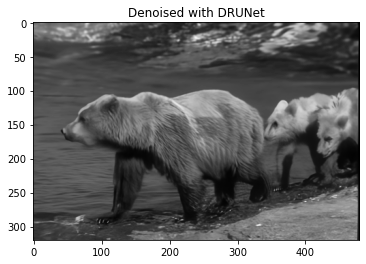

In [6]:
reg_par=0.3*std_noise
xnet=apply_model(xnoisy, model=net, arch='DRUNet', ths=reg_par)
imshowgray(xnet, 'Denoised with DRUNet')

### 1.2- prox wavelet

Reconstruction using  db8  WT


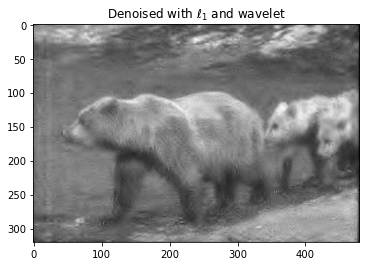

In [7]:
def prox_L1(x, tau):
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)

wave_choice = 'db8'
Psi,Psit = wavelet_op(xnoisy, wav=wave_choice, level=4)
print('Reconstruction using ', wave_choice, ' WT')

reg_par = 0.5*std_noise
xwave = Psit(prox_L1(Psi(xnoisy),reg_par))
imshowgray(xwave, 'Denoised with $\ell_1$ and wavelet')

### 1.4- Comparison

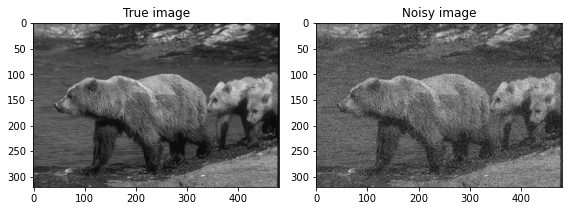

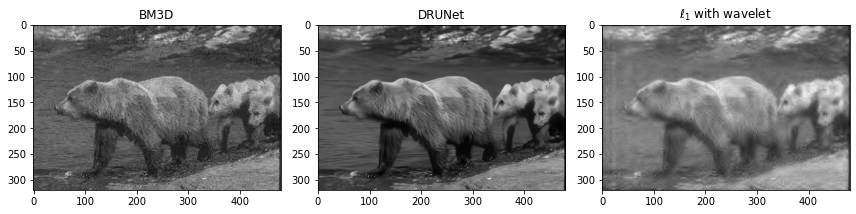

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(xtrue, cmap="gray") 
axs[0].set_title("True image")
axs[1].imshow(xnoisy, cmap="gray")
axs[1].set_title("Noisy image")
fig.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(xbm3d, cmap="gray") 
axs[0].set_title("BM3D")
axs[1].imshow(xnet, cmap="gray")
axs[1].set_title("DRUNet")
axs[2].imshow(xwave, cmap="gray")
axs[2].set_title("$\ell_1$ with wavelet")
fig.tight_layout()

## 2- Plug-and-Play algorithm within FB

### 2.1- Load image, create direct model, and degraded data

Test for deconvolution problem 

Inverse problem: $ z = \Phi \overline{x} + w $ where $\Phi \colon x \in \mathbb{R}^N \to h * x \in \mathbb{R}^N$, $h$ being the convolution kernel (here blur)

#### Feel free to change the model and try other operators $\Phi$!

Display original image size:
(321, 481)


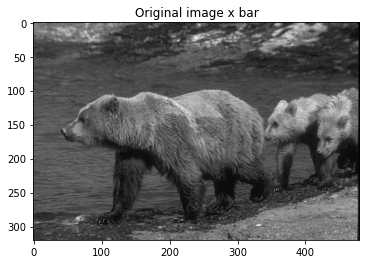

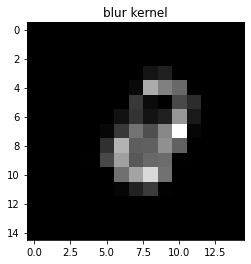

Test adjointness of operator
x shape:  (320, 480)
y shape:  (320, 480)
Phi(x) shape:  (320, 480)
Phit(y) shape:  (320, 480)
forward:  38361.260676096324
backward:  38361.26067609631
-----------------------------
Norm squared of the direct operator:  0.9975409955299486


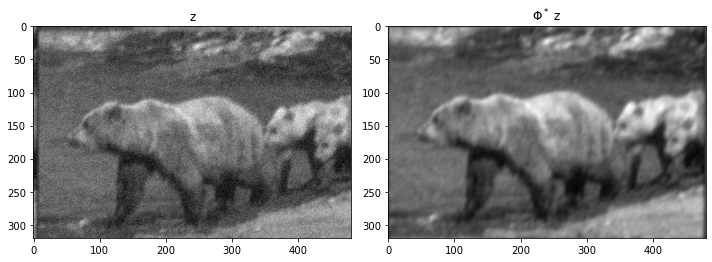

In [9]:
# load image (RGB and convert to grayscale)
im = Image.open('images/bears.jpg').convert('L')
#im = Image.open('images/shepp_logan_phantom.png').convert('L')
#im = Image.open('images/cameraman.png').convert('L')
xtrue = np.array(im) 
xtrue = xtrue / xtrue.max()

print("Display original image size:")
print(xtrue.shape)
# convert to even size
if xtrue.shape[0]%2 == 1:
    xtrue = xtrue[:-1,...]
if xtrue.shape[1]%2 == 1:
    xtrue = xtrue[...,:-1]
nx, ny = xtrue.shape

imshowgray(xtrue, 'Original image x bar')

# load blur kernel
pth_kernel='blur_models/blur_3.mat'
h = scipy.io.loadmat(pth_kernel)
h = np.array(h['blur'])
imshowgray(h, 'blur kernel')

# define operators
Phi, Phit = get_operators(type_op='deconvolution', pth_kernel=pth_kernel)

# test adjoint
test_adj = True
if test_adj is True:
    print('Test adjointness of operator')
    xtmp = np.random.rand(*xtrue.shape)
    Phixtmp = Phi(xtmp)
    ytmp = np.random.rand(*Phixtmp.shape)
    Phitytmp = Phit(ytmp)
    print('x shape: ', xtmp.shape)
    print('y shape: ', ytmp.shape)
    print('Phi(x) shape: ', Phixtmp.shape)
    print('Phit(y) shape: ', Phitytmp.shape)
    fwd = np.sum(xtmp.flatten()*Phitytmp.flatten())
    bwd = np.sum(Phixtmp.flatten()*ytmp.flatten())
    print('forward: ', fwd)
    print('backward: ', bwd)
    print('-----------------------------')
   

# power method to compute spectral norm of Phi
normPhi2 = op_norm2(Phi, Phit, xtrue.shape)
print('Norm squared of the direct operator: ', normPhi2)


# degraded data
x_blurred = Phi(xtrue)
nxb, nyb = x_blurred.shape
std_noise = 0.2
z = x_blurred+std_noise*np.random.rand(nxb,nyb) 
#ntheta = nx #uncomment for tomography
xrec =  Phit(z)

xrec = xrec.reshape(nx, ny)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(z.reshape(nxb, nyb), cmap="gray")
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

fig.tight_layout()


### 2.2- FB with BM3D



Let $\gamma \in ]0,2/\beta[$ and $\operatorname{J}$ be a denoiser, the forward-backard iterations reads:
$$
(\forall k \in \mathbb{N}) \qquad 
x_{k+1}=\operatorname{J}\left(x_{k} - \gamma h(x_k)\right) \\
$$

Here: $\operatorname{J}$ is BM3D denoiser



In [10]:
normPhi2 = op_norm2(Phi, Phit, xrec.shape)
gamma    = 1.99/normPhi2
normPsi2 = op_norm2(Psi, Psit, xrec.shape)

reg_par=0.2*std_noise
niter  = 20



x_n = Phit(z)

table_energy = 1e10*np.ones(niter)
    
for k in range(0,niter):
    g_n = Phit((Phi(x_n) - z))
    tmp = x_n-gamma*g_n
    x_n = bm3d.bm3d(tmp, reg_par)
    table_energy[k] = 0.5*np.sum((Phi(x_n) - z)**2)

xrec_bm3d = x_n  
energy_bm3d = table_energy 


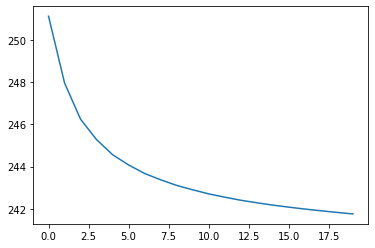

In [11]:
plt.plot(energy_bm3d)

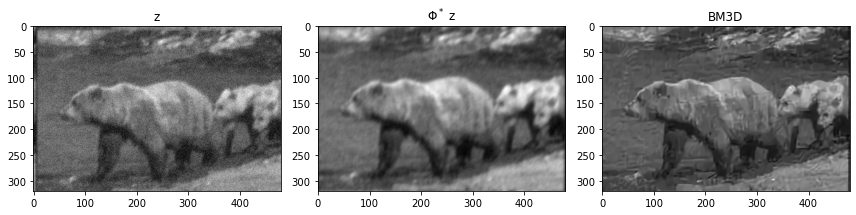

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

axs[2].imshow(xrec_bm3d, cmap="gray")
axs[2].set_title("BM3D")

fig.tight_layout()

### 2.3- FB with DRUNet



Let $\gamma \in ]0,2/\beta[$ and $\operatorname{J}$ be a denoiser, the forward-backard iterations reads:
$$
(\forall k \in \mathbb{N}) \qquad 
x_{k+1}=\operatorname{J}\left(x_{k} - \gamma h(x_k)\right) \\
$$


Here: $\operatorname{J}$ is a NN (DRUNet)



In [13]:
normPhi2 = op_norm2(Phi, Phit, xrec.shape)
gamma    = 1.99/normPhi2
normPsi2 = op_norm2(Psi, Psit, xrec.shape)

reg_par=0.2*std_noise
niter  = 20



x_n = Phit(z)

table_energy = 1e10*np.ones(niter)
    
for k in range(0,niter):
    g_n = Phit((Phi(x_n) - z))
    tmp = x_n-gamma*g_n
    x_n=apply_model(tmp, model=net, arch='DRUNet', ths=reg_par)
    table_energy[k] = 0.5*np.sum((Phi(x_n) - z)**2)

xrec_drunet = x_n  
energy_drunet = table_energy 


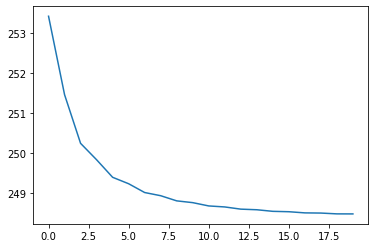

In [14]:
plt.plot(energy_drunet)

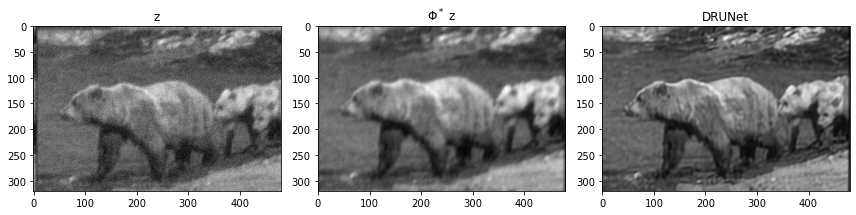

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

axs[2].imshow(xrec_drunet, cmap="gray")
axs[2].set_title("DRUNet")

fig.tight_layout()

### 2.2- FB with prox of $\ell_1$ norm with wavelet transform



Let $\gamma \in ]0,2/\beta[$ and $\operatorname{J}$ be a denoiser, the forward-backard iterations reads:
$$
(\forall k \in \mathbb{N}) \qquad 
x_{k+1}=\operatorname{J}\left(x_{k} - \gamma h(x_k)\right) \\
$$


Here: $\operatorname{J}=\operatorname{prox}_{\gamma \lambda \ell_1 \circ \Psi}$ 



In [20]:
normPhi2 = op_norm2(Phi, Phit, xrec.shape)
gamma    = 1.99/normPhi2
normPsi2 = op_norm2(Psi, Psit, xrec.shape)

reg_par=0.2*std_noise
niter  = 20



x_n = Phit(z)

table_energy = 1e10*np.ones(niter)
    
for k in range(0,niter):
    g_n = Phit((Phi(x_n) - z))
    tmp = x_n-gamma*g_n
    x_n=Psit(prox_L1(Psi(tmp),reg_par*gamma))
    table_energy[k] = 0.5*np.sum((Phi(x_n) - z)**2)

xrec_prox = x_n  
energy_prox = table_energy 


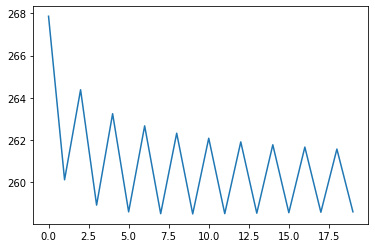

In [21]:
plt.plot(energy_prox)

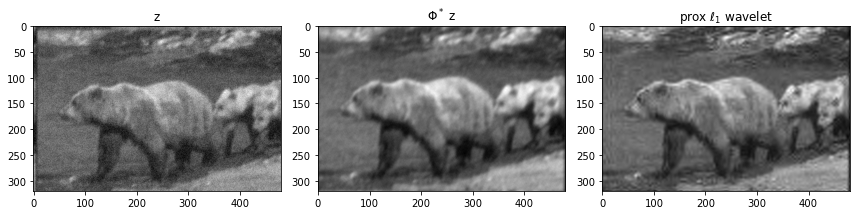

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#axs[0].imshow(z.reshape(ntheta, ny), cmap="gray") #tomography
axs[0].imshow(z.reshape(nx, ny), cmap="gray") #deconvolution
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

axs[2].imshow(xrec_prox, cmap="gray")
axs[2].set_title("prox $\ell_1$ wavelet")

fig.tight_layout()

### 2.4- Comparison

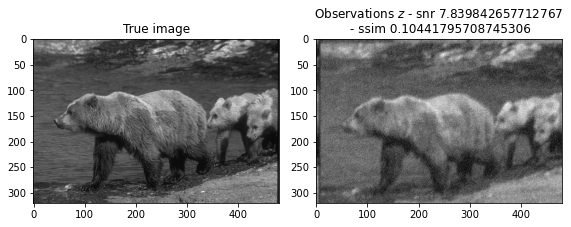

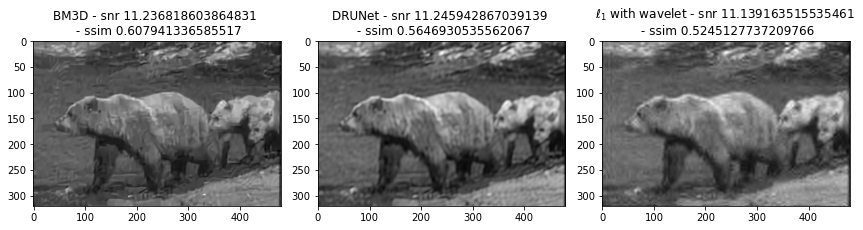

In [27]:
ssim_z = ssim(xtrue, z.reshape(nx, ny), data_range=z.reshape(nx, ny).max() - z.reshape(nx, ny).min())

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(xtrue, cmap="gray") 
axs[0].set_title("True image")
axs[1].imshow(z.reshape(nx, ny), cmap="gray")
axs[1].set_title("Observations $z$ - snr "+str(snr_numpy(xtrue, z.reshape(nx, ny)))+" \n - ssim "+str(ssim_z))
fig.tight_layout()

ssim_bm3d = ssim(xtrue, xrec_bm3d, data_range=xrec_bm3d.max() - xrec_bm3d.min())
ssim_drunet = ssim(xtrue, xrec_drunet, data_range=xrec_drunet.max() - xrec_drunet.min())
ssim_prox = ssim(xtrue, xrec_prox, data_range=xrec_prox.max() - xrec_prox.min())

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(xrec_bm3d, cmap="gray") 
axs[0].set_title("BM3D - snr "+str(snr_numpy(xtrue, xrec_bm3d))+" \n - ssim "+str(ssim_bm3d))
axs[1].imshow(xrec_drunet, cmap="gray")
axs[1].set_title("DRUNet - snr "+str(snr_numpy(xtrue, xrec_drunet))+" \n - ssim "+str(ssim_drunet))
axs[2].imshow(xrec_prox, cmap="gray")
axs[2].set_title("$\ell_1$ with wavelet - snr "+str(snr_numpy(xtrue, xrec_prox))+" \n - ssim "+str(ssim_prox))
fig.tight_layout()

